In [1]:
# =============================================================================
# 0. IMPORTS AND SETTINGS
# =============================================================================
import sys, os, warnings
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import pymc as pm, arviz as az

os.chdir('game-behavior-analytics/data_analysis_notebook/')
sys.path.append(os.path.abspath('utils'))
warnings.filterwarnings('ignore')

from data_utils import load_and_prepare_data
from metadata import theory_order, theory_map

# Load and preprocess data
df, concepts = load_and_prepare_data("../data/final_dataset.csv")


In [2]:
# =============================================================================
# 1. CHEATING BEHAVIOR DISTRIBUTION BY CONCEPT
# =============================================================================
cheating_dist = pd.crosstab(df['concept'], df['cheating_behavior'], margins=True)
cheating_dist.columns = ['Non-cheater','Partial-cheater','Full-cheater','Total']

print("Cheating Behavior Distribution by Concept:")
print("="*60)

for concept in ['control'] + concepts:
    if concept in cheating_dist.index:
        row = cheating_dist.loc[concept]
        print(f"{concept:<25} | Non: {row[0]:>3} ({row[0]/row['Total']*100:>4.1f}%) | "
              f"Partial: {row[1]:>3} ({row[1]/row['Total']*100:>4.1f}%) | "
              f"Full: {row[2]:>3} ({row[2]/row['Total']*100:>4.1f}%) | Total: {row['Total']:>3}")

print("-"*60)
total_row = cheating_dist.loc['All']
print(f"{'OVERALL':<25} | Non: {total_row[0]:>3} ({total_row[0]/total_row['Total']*100:>4.1f}%) | "
      f"Partial: {total_row[1]:>3} ({total_row[1]/total_row['Total']*100:>4.1f}%) | "
      f"Full: {total_row[2]:>3} ({total_row[2]/total_row['Total']*100:>4.1f}%) | Total: {total_row['Total']:>3}")


Cheating Behavior Distribution by Concept:
control                   | Non:  39 (53.4%) | Partial:  10 (13.7%) | Full:  24 (32.9%) | Total:  73
autonomy                  | Non:  50 (65.8%) | Partial:  15 (19.7%) | Full:  11 (14.5%) | Total:  76
cognitive_inconsistency   | Non:  51 (67.1%) | Partial:  15 (19.7%) | Full:  10 (13.2%) | Total:  76
competence                | Non:  51 (66.2%) | Partial:  10 (13.0%) | Full:  16 (20.8%) | Total:  77
descriptive_norms         | Non:  51 (63.7%) | Partial:  17 (21.2%) | Full:  12 (15.0%) | Total:  80
dissonance_arousal        | Non:  49 (63.6%) | Partial:   9 (11.7%) | Full:  19 (24.7%) | Total:  77
dissonance_reduction      | Non:  48 (61.5%) | Partial:  18 (23.1%) | Full:  12 (15.4%) | Total:  78
emotional_arousal         | Non:  44 (57.1%) | Partial:  14 (18.2%) | Full:  19 (24.7%) | Total:  77
injunctive_norms          | Non:  47 (60.3%) | Partial:  12 (15.4%) | Full:  19 (24.4%) | Total:  78
performance_accomplishments | Non:  44 (57.1%) |

Fitting RQ1: Cheating Behavior Model...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_partial_intercept, beta_full_intercept, mu_partial, sigma_partial, concept_effects_partial, mu_full, sigma_full, concept_effects_full]


Output()

Sampling 4 chains for 2_500 tune and 1_500 draw iterations (10_000 + 6_000 draws total) took 185 seconds.
There were 468 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [beta_full_intercept, beta_partial_intercept, cheating_observed, concept_effects_full, concept_effects_partial, mu_full, mu_partial, sigma_full, sigma_partial]
Sampling: [cheating_observed]


Output()

<Axes: xlabel='cheating_observed'>

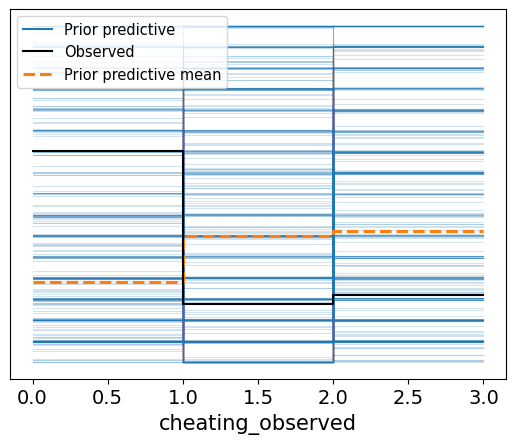

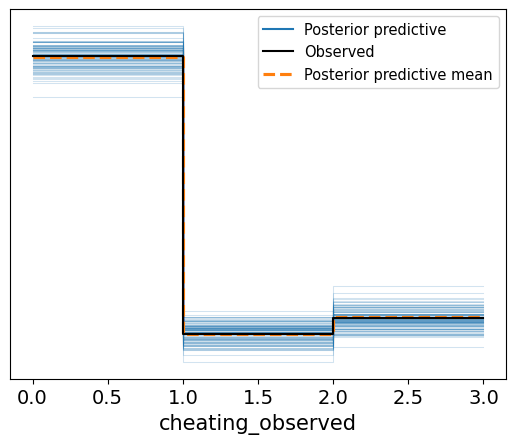

In [3]:
# =============================================================================
# 2. RQ1: CHEATING BEHAVIOR MODEL
# =============================================================================
def build_cheating_model(df, concepts):
    with pm.Model() as model:
        # Intercepts
        beta_partial = pm.Normal('beta_partial_intercept', mu=0, sigma=100)
        beta_full = pm.Normal('beta_full_intercept', mu=0, sigma=100)
        
        # Concept-level effects
        def concept_effects(name):
            mu = pm.Normal(f'mu_{name}', 0, 100)
            sigma = pm.HalfNormal(f'sigma_{name}', 100)
            return pm.Normal(f'concept_effects_{name}', mu=mu, sigma=sigma, shape=len(concepts))
        
        concept_partial, concept_full = concept_effects('partial'), concept_effects('full')
        
        # Linear logits
        idx = df['concept_idx'].values
        partial_fx = pm.math.switch(idx>0, concept_partial[idx-1], 0)
        full_fx = pm.math.switch(idx>0, concept_full[idx-1], 0)
        logits = pm.math.stack([pm.math.zeros_like(partial_fx), beta_partial+partial_fx, beta_full+full_fx], axis=1)
        pm.Categorical('cheating_observed', p=pm.math.softmax(logits, axis=1), observed=df['cheating_behavior'].values)
    return model

def sample_model(model, draws=1500, tune=2500, chains=4, cores=4, target_accept=0.95, max_treedepth=12, init="jitter+adapt_diag", random_seed=42):
    with model:
        return pm.sample(draws=draws, tune=tune, chains=chains, cores=cores,
                         target_accept=target_accept, max_treedepth=max_treedepth, init=init, random_seed=random_seed)

print("Fitting RQ1: Cheating Behavior Model...")
cheating_model = build_cheating_model(df, concepts)
trace_cheating = sample_model(cheating_model)
az.to_netcdf(trace_cheating, "notebook/trace_cheating.nc")

# Posterior Predictive Check
with cheating_model:
    ppc_prior = pm.sample_prior_predictive()
    ppc_post = pm.sample_posterior_predictive(trace_cheating, random_seed=42)
az.plot_ppc(ppc_prior, group='prior', observed=True)
az.plot_ppc(ppc_post, num_pp_samples=100)


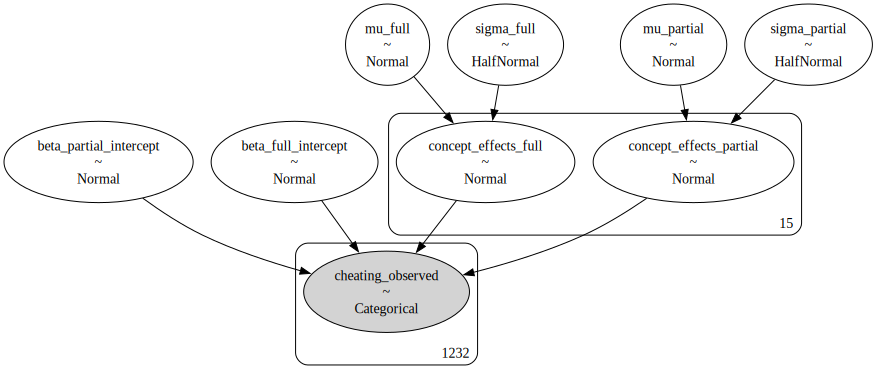

In [4]:
pm.model_to_graphviz(cheating_model)

In [5]:
# =============================================================================
# AFTER SAMPLING: EXTRACT POSTERIOR ARRAYS ONCE
# =============================================================================

beta_partial = trace_cheating.posterior['beta_partial_intercept'].values.flatten()
beta_full = trace_cheating.posterior['beta_full_intercept'].values.flatten()
partial_fx = trace_cheating.posterior['concept_effects_partial'].values.reshape(-1, len(concepts))
full_fx = trace_cheating.posterior['concept_effects_full'].values.reshape(-1, len(concepts))

# --- CONTROL PROBABILITIES ---
control_logits = np.column_stack([np.zeros_like(beta_partial), beta_partial, beta_full])
control_probs = np.exp(control_logits) / np.exp(control_logits).sum(axis=1, keepdims=True)

# --- HDIs for control ---
control_hdi = az.hdi(control_probs, hdi_prob=0.89)

# --- FUNCTION TO COMPUTE CONCEPT PROBS AND HDIs ---
def concept_probs_and_hdi(idx):
    logits = np.column_stack([
        np.zeros_like(beta_partial),
        beta_partial + partial_fx[:, idx],
        beta_full + full_fx[:, idx]
    ])
    probs = np.exp(logits) / np.exp(logits).sum(axis=1, keepdims=True)
    diffs = probs - control_probs  # difference from control
    hdi_vals = az.hdi(diffs, hdi_prob=0.89)
    mean_diff = diffs.mean(axis=0)
    return probs, diffs, mean_diff, hdi_vals


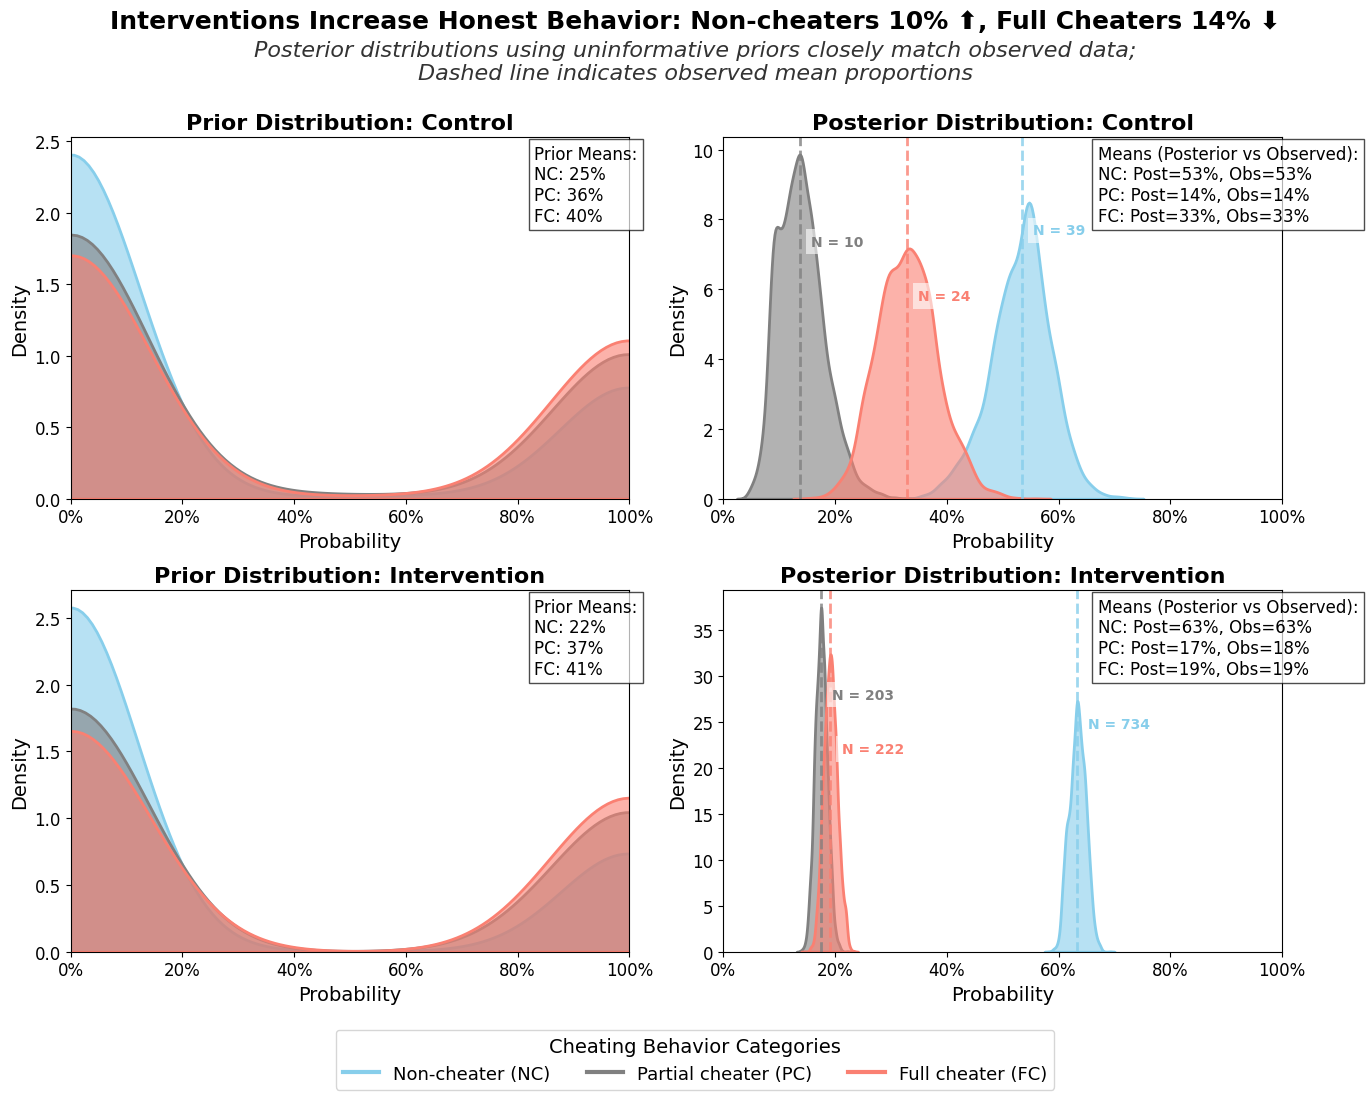

In [6]:
# =============================================================================
# 3. PRIOR VS POSTERIOR VALIDATION PLOT
# =============================================================================

def plot_bayesian_validation(trace_cheating, ppc_prior, df, concepts):
    """Fixed version that uses the correct variable names from previous cells"""
    
    # Extract posterior samples (reusing existing pattern)
    beta_partial = trace_cheating.posterior['beta_partial_intercept'].values.flatten()
    beta_full = trace_cheating.posterior['beta_full_intercept'].values.flatten()
    partial_effects = trace_cheating.posterior['concept_effects_partial'].values.reshape(-1, len(concepts))
    full_effects = trace_cheating.posterior['concept_effects_full'].values.reshape(-1, len(concepts))
    
    # Extract prior samples
    prior_partial = ppc_prior.prior['beta_partial_intercept'].values.flatten()
    prior_full = ppc_prior.prior['beta_full_intercept'].values.flatten()
    prior_partial_fx = ppc_prior.prior['concept_effects_partial'].values.reshape(-1, len(concepts))
    prior_full_fx = ppc_prior.prior['concept_effects_full'].values.reshape(-1, len(concepts))
    
    # Softmax conversion function
    def to_probs(logits):
        exp_logits = np.exp(logits)
        return exp_logits / exp_logits.sum(axis=1, keepdims=True)
    
    # Calculate probability distributions
    prior_control = to_probs(np.column_stack([np.zeros_like(prior_partial), prior_partial, prior_full]))
    posterior_control = to_probs(np.column_stack([np.zeros_like(beta_partial), beta_partial, beta_full]))
    
    prior_intervention = to_probs(np.column_stack([
        np.zeros_like(prior_partial), 
        prior_partial + prior_partial_fx.mean(axis=1),
        prior_full + prior_full_fx.mean(axis=1)
    ]))
    posterior_intervention = to_probs(np.column_stack([
        np.zeros_like(beta_partial),
        beta_partial + partial_effects.mean(axis=1),
        beta_full + full_effects.mean(axis=1)
    ]))
    
    # Observed proportions
    control_obs = df[df['concept'] == 'control']['cheating_behavior'].value_counts(normalize=True).sort_index()
    intervention_obs = df[df['concept'] != 'control']['cheating_behavior'].value_counts(normalize=True).sort_index()
    
    # Rest of the plotting code remains the same...
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    categories = ['Non-cheater (NC)', 'Partial cheater (PC)', 'Full cheater (FC)']
    short_cats = ['NC', 'PC', 'FC']
    colors = ['skyblue', 'gray', 'salmon']
    
    for row, (prior_data, post_data, obs_data, row_title) in enumerate([
        (prior_control, posterior_control, control_obs, 'Control'),
        (prior_intervention, posterior_intervention, intervention_obs, 'Intervention')
    ]):
        
        # Prior (left)
        ax_prior = axes[row, 0]
        prior_means = []
        for i, (cat, color) in enumerate(zip(categories, colors)):
            sns.kdeplot(prior_data[:, i], ax=ax_prior, color=color, fill=True, alpha=0.6, linewidth=2)
            prior_means.append(prior_data[:, i].mean())
        
        ax_prior.set_title(f'Prior Distribution: {row_title}', fontweight='bold', fontsize=16)
        ax_prior.set_xlim(0, 1)
        ax_prior.set_xlabel('Probability', fontsize=14)
        ax_prior.set_ylabel('Density', fontsize=14)
        ax_prior.tick_params(axis='both', labelsize=12)
        ax_prior.xaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1.0))
        
        prior_text = '\n'.join([f'{cat}: {mean:.0%}' for cat, mean in zip(short_cats, prior_means)])
        ax_prior.text(0.83, 0.98, f'Prior Means:\n{prior_text}', transform=ax_prior.transAxes,
                      va='top', bbox=dict(facecolor='white', alpha=0.7), fontsize=12)
        
        # Posterior (right)
        ax_post = axes[row, 1]
        posterior_means = []
        observed_means = []

        # Get counts for this group
        if row == 0:  # Control
            group_data = df[df['concept'] == 'control']
        else:  # Intervention
            group_data = df[df['concept'] != 'control']

        group_counts = group_data['cheating_behavior'].value_counts().sort_index()

        for i, (cat, color) in enumerate(zip(categories, colors)):
            sns.kdeplot(post_data[:, i], ax=ax_post, color=color, fill=True, alpha=0.6, linewidth=2)

            # Observed mean line
            obs_mean = obs_data.iloc[i]
            ax_post.axvline(obs_mean, color=color, linestyle='--', linewidth=2, alpha=0.8)

            posterior_means.append(post_data[:, i].mean())
            observed_means.append(obs_mean)

            # Individual N label near each curve
            ax_post.text(
                obs_mean + 0.02,    # small offset from vertical line
                ax_post.get_ylim()[1] * (0.85 - i*0.15),  # stagger vertically
                f"N = {group_counts.get(i, 0)}",
                fontsize=10, fontweight='bold', color=color,
                bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
            )

        ax_post.set_title(f'Posterior Distribution: {row_title}', fontweight='bold', fontsize=16)
        ax_post.set_xlim(0, 1)
        ax_post.set_xlabel('Probability', fontsize=14)
        ax_post.set_ylabel('Density', fontsize=14)
        ax_post.tick_params(axis='both', labelsize=12)
        ax_post.xaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1.0))

        post_text = '\n'.join([
            f'{cat}: Post={post:.0%}, Obs={obs:.0%}' 
            for cat, post, obs in zip(short_cats, posterior_means, observed_means)
        ])
        ax_post.text(
            0.67, 0.98, f'Means (Posterior vs Observed):\n{post_text}',
            transform=ax_post.transAxes, va='top', bbox=dict(facecolor='white', alpha=0.7), fontsize=12
        )
    
    # Shared legend
    legend_elements = [plt.Line2D([0], [0], color=color, linewidth=3, label=cat) 
                      for cat, color in zip(categories, colors)]
    fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.06), 
               ncol=3, fontsize=13, title='Cheating Behavior Categories', title_fontsize=14)
    
    # Title & subtitle with spacing
    plt.suptitle(
        'Interventions Increase Honest Behavior: Non-cheaters 10% ⬆️, Full Cheaters 14% ⬇️',
        fontsize=18, fontweight='bold', y=1.03
    )
    plt.figtext(
        0.5, 0.96,
        'Posterior distributions using uninformative priors closely match observed data;\nDashed line indicates observed mean proportions',
        ha='center', fontsize=16, style='italic', color='black', alpha=0.8
    )
    
    plt.tight_layout(rect=[0, 0.02, 1, 0.98])
    plt.show()

plot_bayesian_validation(trace_cheating, ppc_prior, df, concepts)

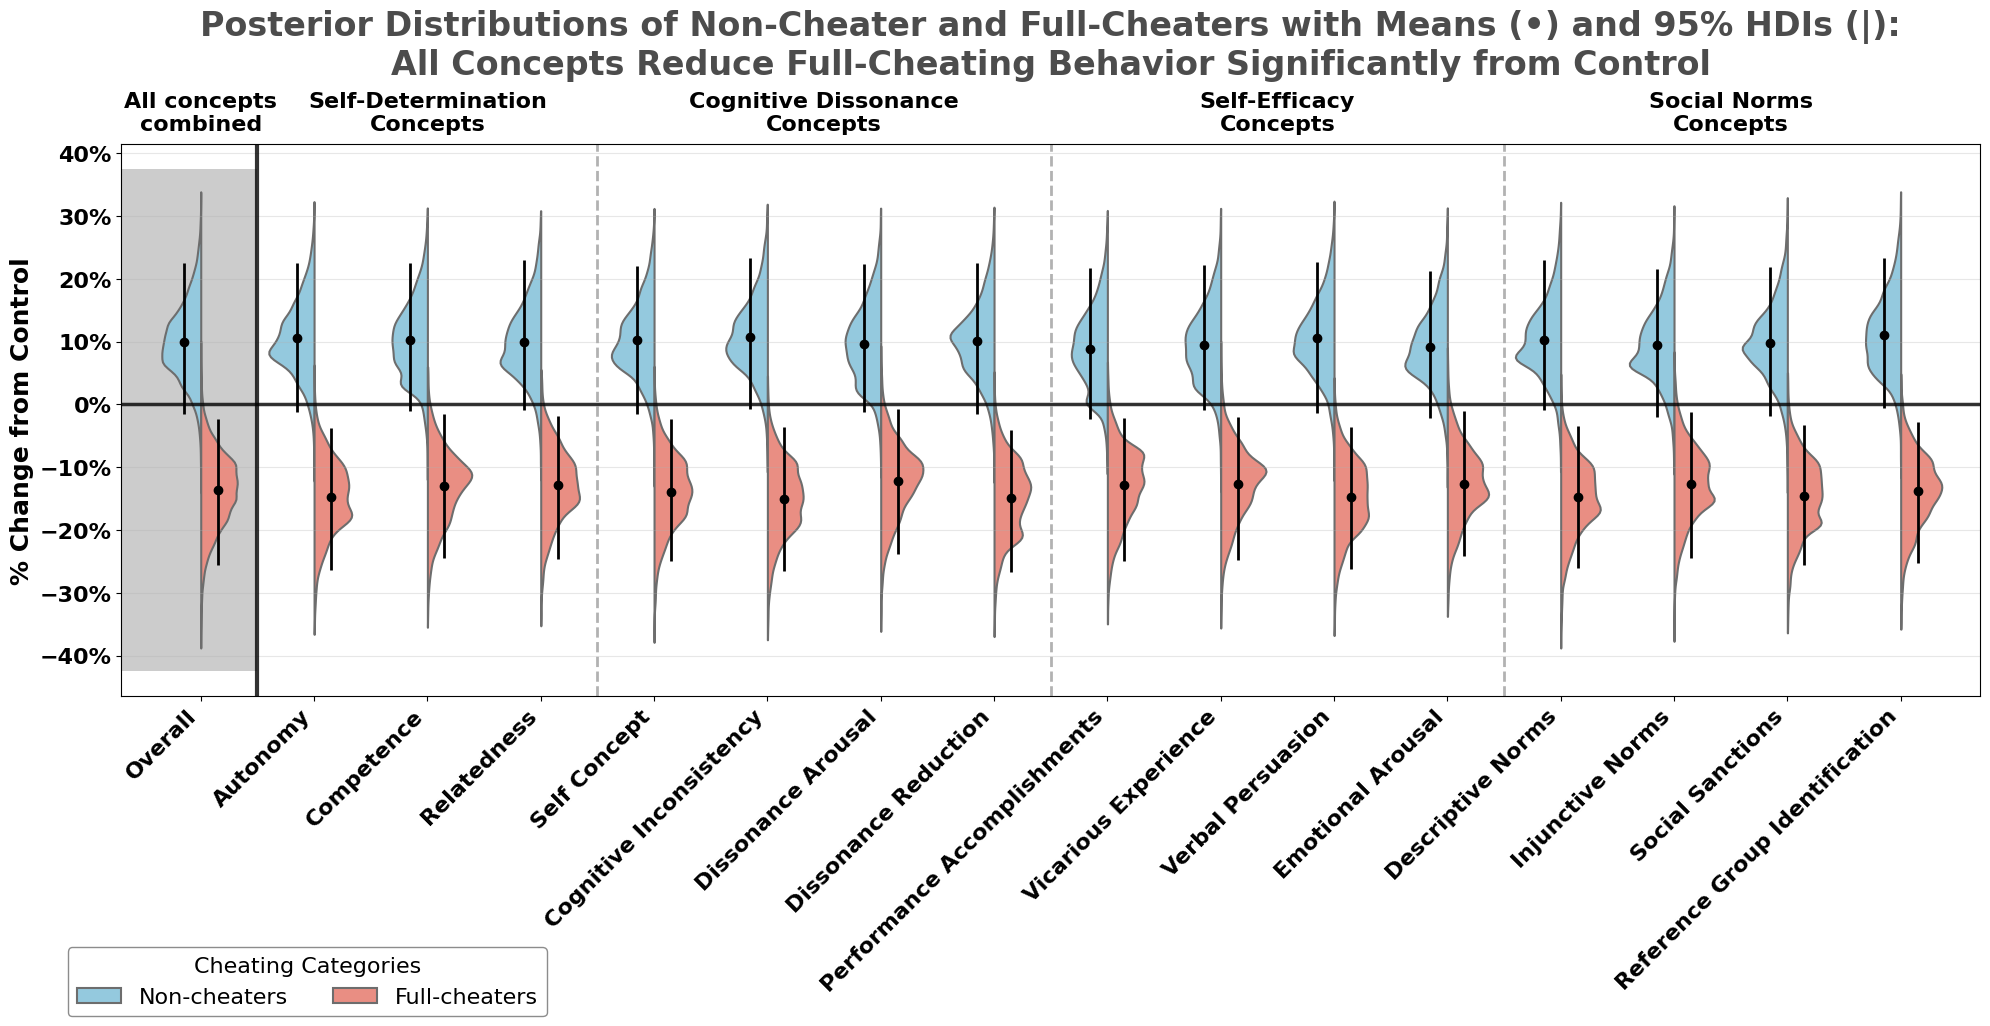

In [ ]:
# ================================
# 4. IMPACT SPECTRUM VIOLIN PLOT
# ================================

from matplotlib.ticker import PercentFormatter
def create_impact_spectrum_violin(beta_partial, beta_full, partial_fx, full_fx, 
                                         control_probs, concepts, theory_order, theory_map):
    """Violin plot that reuses precomputed posterior samples and probabilities."""
    
    # Collect concept-specific data (reusing existing arrays)
    concept_rows = []
    theory_groups = {}
    
    for concept in theory_order:
        if concept not in concepts:
            continue
        idx = concepts.index(concept)
        theory = theory_map[concept]
        
        if theory not in theory_groups:
            theory_groups[theory] = []
        theory_groups[theory].append(concept.replace('_', ' ').title())
        
        # Reuse existing softmax calculation pattern
        concept_logits = np.column_stack([
            np.zeros_like(beta_partial),
            beta_partial + partial_fx[:, idx], 
            beta_full + full_fx[:, idx]
        ])
        concept_probs = np.exp(concept_logits) / np.exp(concept_logits).sum(axis=1, keepdims=True)
        
        non_diff = (concept_probs[:, 0] - control_probs[:, 0]) * 100
        full_diff = (concept_probs[:, 2] - control_probs[:, 2]) * 100
        
        concept_name = concept.replace('_', ' ').title()
        
        for v in non_diff:
            concept_rows.append({"concept": concept_name, "group": "Non-cheaters", 
                               "effect": v, "theory": theory})
        for v in full_diff:
            concept_rows.append({"concept": concept_name, "group": "Full-cheaters", 
                               "effect": v, "theory": theory})
    
    # Create ordered concept list by theory
    ordered_concepts = []
    theory_order_viz = ['Self-Determination Theory', 'Cognitive Dissonance Theory', 
                       'Self-Efficacy Theory', 'Social Norms Theory']
    
    for theory in theory_order_viz:
        if theory in theory_groups:
            ordered_concepts.extend(theory_groups[theory])
    
    # Add Overall data
    df_concepts = pd.DataFrame(concept_rows)
    overall_non = df_concepts[df_concepts["group"] == "Non-cheaters"]["effect"].values
    overall_full = df_concepts[df_concepts["group"] == "Full-cheaters"]["effect"].values
    
    overall_rows = []
    for v in overall_non:
        overall_rows.append({"concept": "Overall", "group": "Non-cheaters", 
                           "effect": v, "theory": "Overall"})
    for v in overall_full:
        overall_rows.append({"concept": "Overall", "group": "Full-cheaters", 
                           "effect": v, "theory": "Overall"})
    
    df_all = pd.DataFrame(overall_rows + concept_rows)
    final_order = ["Overall"] + ordered_concepts
    df_all['concept'] = pd.Categorical(df_all['concept'], categories=final_order, ordered=True)
    df_all = df_all.sort_values('concept')
    
    # Create the plot (plot code remains the same)
    fig, ax = plt.subplots(figsize=(20, 8))
    
    palette = {"Non-cheaters": "skyblue", "Full-cheaters": "salmon"}
    
    sns.violinplot(data=df_all, x="concept", y="effect", hue="group",
                   split=True, inner=None, linewidth=1.5, cut=0, palette=palette, ax=ax)
    
    # Highlight Overall section
    overall_rect = plt.Rectangle(
        (-0.7, ax.get_ylim()[0]), 1.2, ax.get_ylim()[1] - ax.get_ylim()[0],
        facecolor='gray', alpha=0.4, zorder=0
    )
    ax.add_patch(overall_rect)
    
    # Add theory separators
    current_pos = 1
    for theory in theory_order_viz:
        if theory in theory_groups:
            theory_concepts = theory_groups[theory]
            start_pos = current_pos - 0.5
            if current_pos > 1:
                ax.axvline(start_pos, color='gray', linestyle='--', 
                           linewidth=2, alpha=0.6, zorder=1)
            current_pos += len(theory_concepts)
    
    ax.axvline(0.5, color='black', linestyle='-', linewidth=3, alpha=0.8, zorder=2)
    
    # Add posterior means and HDIs
    for i, concept in enumerate(final_order):
        for group in ["Non-cheaters", "Full-cheaters"]:
            subset = df_all[(df_all['concept'] == concept) & (df_all['group'] == group)]['effect'].values
            if len(subset) == 0:
                continue
            mean_val = np.mean(subset)
            hdi_low, hdi_high = az.hdi(subset, hdi_prob=0.95)
            x_pos = i - 0.15 if group == "Non-cheaters" else i + 0.15
            ax.plot(x_pos, mean_val, 'o', color='black', markersize=6, zorder=3)
            ax.vlines(x_pos, hdi_low, hdi_high, color='black', linewidth=2, zorder=3)
    
    # Styling and labels (same as original)
    ax.axhline(0, color="black", linewidth=2.5, alpha=0.8, zorder=2)
    ax.set_ylabel("% Change from Control", fontsize=18, fontweight="bold")
    ax.set_xlabel("", fontsize=1)
    ax.grid(True, alpha=0.3, axis="y", zorder=0)
    
    plt.xticks(rotation=45, ha="right", fontsize=16, fontweight="bold")
    plt.yticks(fontsize=16, fontweight="bold")
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=100))
    
    # Theory labels above
    y_top = ax.get_ylim()[1]
    label_height = y_top * 1.12
    
    ax.text(0, label_height, "All concepts\ncombined", ha='center', va='center', 
            fontsize=16, fontweight='bold', color='black')
    
    short_names = {
        'Self-Determination Theory': 'Self-Determination\nConcepts', 
        'Cognitive Dissonance Theory': 'Cognitive Dissonance\nConcepts',
        'Self-Efficacy Theory': 'Self-Efficacy\nConcepts', 
        'Social Norms Theory': 'Social Norms\nConcepts'
    }
    
    current_pos = 1
    for theory in theory_order_viz:
        if theory in theory_groups:
            theory_concepts = theory_groups[theory]
            start_pos = current_pos
            end_pos = current_pos + len(theory_concepts) - 1
            mid_pos = (start_pos + end_pos) / 2
            ax.text(mid_pos, label_height, short_names[theory], 
                    ha='center', va='center', fontsize=16, fontweight='bold', color='black')
            current_pos += len(theory_concepts)
    
    ax.set_xlim(-0.7, len(final_order) - 0.3)
    
    plt.title("Posterior Distributions of Non-Cheater and Full-Cheaters with Means (•) and 95% HDIs (|):\n" +
              "All Concepts Reduce Full-Cheating Behavior Significantly from Control", 
              fontsize=24, color="black", alpha=0.7, fontweight="bold", pad=50)
    
    legend = ax.legend(title="Cheating Categories", fontsize=16, title_fontsize=16, 
                       loc='lower center', bbox_to_anchor=(0.1, -0.6), ncol=2)
    legend.get_frame().set_alpha(0.9)
    legend.get_frame().set_edgecolor('gray')
    legend.get_frame().set_linewidth(1)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.99, bottom=0.3)
    plt.show()



create_impact_spectrum_violin(beta_partial, beta_full, partial_fx, full_fx, 
                            control_probs, concepts, theory_order, theory_map)


In [10]:
def print_posterior_values_table(trace_cheating, concepts, theory_order, theory_map):
    """Print posterior % point changes from control with 95% HDI, reusing computed probabilities."""

    # --- Function to get % point changes for a concept ---
    def concept_effect(idx):
        logits = np.column_stack([
            np.zeros_like(beta_partial),
            beta_partial + partial_fx[:, idx],
            beta_full + full_fx[:, idx]
        ])
        probs = np.exp(logits) / np.exp(logits).sum(axis=1, keepdims=True)
        return (probs - control_probs) * 100  # % point change

    # --- Overall ---
    all_effects = np.vstack([concept_effect(concepts.index(c)) for c in theory_order if c in concepts])
    non_mean, partial_mean, full_mean = all_effects.mean(axis=0)  # 2D array → axis=0
    non_hdi, partial_hdi, full_hdi = [az.hdi(all_effects[:,i], hdi_prob=0.95) for i in range(3)]

    print("="*120)
    print(f"{'OVERALL':<25} {'All Theories':<25} "
          f"Non={non_mean:.2f} [{non_hdi[0]:.2f},{non_hdi[1]:.2f}], "
          f"Partial={partial_mean:.2f} [{partial_hdi[0]:.2f},{partial_hdi[1]:.2f}], "
          f"Full={full_mean:.2f} [{full_hdi[0]:.2f},{full_hdi[1]:.2f}]")
    print("="*120)

    # --- By theory & concept ---
    theory_groups = {}
    for c in theory_order:
        if c in concepts:
            theory_groups.setdefault(theory_map[c], []).append(c)

    for th in ['Self-Determination Theory', 'Cognitive Dissonance Theory', 
               'Self-Efficacy Theory', 'Social Norms Theory']:
        if th not in theory_groups:
            continue
        print(f"\n{th.upper()}")
        print("-"*120)
        for c in theory_groups[th]:
            idx = concepts.index(c)
            effects = concept_effect(idx)
            mean_vals = effects.mean(axis=0)
            hdi_vals = [az.hdi(effects[:,i], hdi_prob=0.95) for i in range(3)]
            print(f"{c.replace('_',' ').title():<25} Non={mean_vals[0]:.2f} [{hdi_vals[0][0]:.2f},{hdi_vals[0][1]:.2f}], "
                  f"Partial={mean_vals[1]:.2f} [{hdi_vals[1][0]:.2f},{hdi_vals[1][1]:.2f}], "
                  f"Full={mean_vals[2]:.2f} [{hdi_vals[2][0]:.2f},{hdi_vals[2][1]:.2f}]")
print_posterior_values_table(trace_cheating, concepts, theory_order, theory_map)

OVERALL                   All Theories              Non=10.00 [-1.45,22.47], Partial=3.67 [-5.90,12.09], Full=-13.67 [-25.57,-2.35]

SELF-DETERMINATION THEORY
------------------------------------------------------------------------------------------------------------------------
Autonomy                  Non=10.53 [-1.12,22.48], Partial=4.22 [-4.66,13.09], Full=-14.75 [-26.39,-3.81]
Competence                Non=10.20 [-1.09,22.47], Partial=2.86 [-6.48,10.83], Full=-13.06 [-24.48,-1.49]
Relatedness               Non=9.98 [-0.82,23.08], Partial=2.82 [-6.58,10.58], Full=-12.79 [-24.67,-1.85]

COGNITIVE DISSONANCE THEORY
------------------------------------------------------------------------------------------------------------------------
Self Concept              Non=10.22 [-1.47,22.00], Partial=3.64 [-5.23,12.40], Full=-13.86 [-25.01,-2.36]
Cognitive Inconsistency   Non=10.75 [-0.76,23.28], Partial=4.24 [-4.80,12.83], Full=-14.99 [-26.48,-3.60]
Dissonance Arousal        Non=9.64 [-1.16